In [1]:
import helper
from helper import *
import importlib
importlib.reload(helper)

df = load_merged_data(only_standard_refuelling=True)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class FurnaceModelTrainer:
    def __init__(self, df, input_columns, slice_step=1, cross_validation_splitter=TimeSeriesSplit(n_splits=5), cross_validation_params=None, skip_first_cv_splits=0, model_builder=lambda: LinearRegression(), fit_params=None):
        self.df = df
        self.slice_step = slice_step
        self.input_columns = input_columns
        self.cross_validation_splitter = cross_validation_splitter
        self.cross_validation_params = cross_validation_params
        if self.cross_validation_params is None:
            self.cross_validation_params = {}
        self.skip_first_cv_splits = skip_first_cv_splits
        self.model_builder = model_builder
        self.fit_params = fit_params
        if self.fit_params is None:
            self.fit_params = {}
        
        self.X, self.y = split_xy(self.df, self.input_columns)
        self.model = None
        self.cross_validation_models = None
        
        
    def cross_validation(self):
        mape_scores = []
        mse_scores = []
        self.cross_validation_models = []
        
        splits = self.cross_validation_splitter.split(self.X, **self.cross_validation_params)
        
        for i in range(self.skip_first_cv_splits):
            next(splits)
        
        for train_index, test_index in splits:
            train_index = train_index[::self.slice_step]
            test_index = test_index[::self.slice_step]
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            data_train, data_test = self.df.iloc[train_index], self.df.iloc[test_index]

            model = self.model_builder()
            model.fit(X_train, y_train, **self.fit_params)

            y_pred = model.predict(X_test)
            
            mape = mean_absolute_percentage_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)

            mape_scores.append(mape)
            mse_scores.append(mse)
            self.cross_validation_models.append((model, X_train, X_test, y_train, y_test, data_train, data_test))
            
            print(f"Statistics for this fold: {mape}, {mse}, {np.sqrt(mse)}")
            
        avg_mape = np.mean(mape_scores)
        avg_mse = np.mean(mse_scores)
        
        print(f"Average MAPE: {avg_mape}")
        print(f"Average MSE: {avg_mse}")
        print(f"Average RSME: {np.sqrt(avg_mse)}")
        
    def train(self):
        self.model = self.model_builder()
        X = self.X[::self.slice_step]
        y = self.y[::self.slice_step]
        self.model.fit(X, y, **self.fit_params)
        
        return self.model
    
    def split_data(self, n=-1):
        model, X_train, X_test, y_train, y_test, data_train, data_test = self.cross_validation_models[n]
        
        y_pred = model.predict(X_test)
        
        return model, X_train, X_test, y_train, y_test, data_train, data_test, y_pred
    
    def visualize_split_scatter(self, n=-1):
        model, X_train, X_test, y_train, y_test, data_train, data_test, y_pred = self.split_data(n)
        sns.scatterplot(x=y_test, y=y_pred)
        plt.plot([0, 100], [0, 100], color='red', lw=3)
        
    def visualize_split_example(self, n=-1, days=5):
        model, X_train, X_test, y_train, y_test, data_train, data_test, y_pred = self.split_data(n)
        
        start_date = data_test['date'].iloc[0]
        end_date = start_date + pd.Timedelta(days=days)

        # data for plot
        data_display = data_test.loc[(data_test['date'] >= start_date) & (data_test['date'] <= end_date)]
        y_pred_display = y_pred[:len(data_display)]

        sns.lineplot(x=data_display['date'], y=data_display['refuellingTimePointActual'], label='actual')
        sns.scatterplot(x=data_display['date'], y=y_pred_display, label='predicted', color='red')
        sns.scatterplot(x=data_display['date'], y=data_display['refuellingTimePoint'], label='Ofen Vorhersage', color='blue')
        
        # set figure size
        plt.gcf().set_size_inches(16, 8)
        
    def visualize_split(self, n=-1, days=5):
        plt.subplot(2, 1, 1)
        self.visualize_split_scatter(n)
        plt.subplot(2, 1, 2)
        self.visualize_split_example(n, days)
        
        

In [3]:
input_columns = [
    'refuellingTimePoint', 'refuellingTimePoint_5', 'refuellingTimePoint_10', 'refuellingTimePoint_15', 'refuellingTimePoint_30', 'refuellingTimePoint_60',
    'bufferChargingDegree', 'bufferChargingDegree_5', 'bufferChargingDegree_10', 'bufferChargingDegree_15', 'bufferChargingDegree_30', 'bufferChargingDegree_60',
    'Anheizen', 'Anzünden', 'Ausbrennen', 'Ausgeschaltet', 'Automatik', 'Vorbelüften', 'Zündung bereit',
    'Year sin', 'Year cos',
    'refuellingQuantity',
    'residualOxygen', 'flueGasTemperature',
    'bufferTemperatureTop', 'bufferTemperatureMiddleTop', 'bufferTemperatureMiddle', 'bufferTemperatureMiddleBottom', 'bufferTemperatureBottom',
    'bufferUsableEnergyMax', 'bufferUsableEnergyActual',
    'outsideTemperature',
    'weatherTemperature', 'weatherWindX', 'weatherWindY',
    'weatherTemperature_6', 'weatherWindX_6', 'weatherWindY_6',
    'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12',
    'weatherTemperature_18', 'weatherWindX_18', 'weatherWindY_18',
    'weatherTemperature_24', 'weatherWindX_24', 'weatherWindY_24'
]

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor

gradientBoostingTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=TimeSeriesSplit(n_splits=5), skip_first_cv_splits=2,
    model_builder=lambda: GradientBoostingRegressor())
# gradientBoostingTrainer = FurnaceModelTrainer(df, input_columns, slice_step=100, cross_validation_splitter=GroupKFold(n_splits=5), cross_validation_params={'groups': df['refuellingDateActual']}, model_builder=lambda: GradientBoostingRegressor())

gradientBoostingTrainer.cross_validation()

Statistics for this fold: 0.5004597511393001, 18.577576367896615, 4.31017126897489
Statistics for this fold: 0.2999595357623245, 137.09344628187156, 11.708691057580756
Statistics for this fold: 0.5424367943042745, 65.67424450589482, 8.10396473992174
Average MAPE: 0.4476186937352997
Average MSE: 73.78175571855434
Average RSME: 8.58963070909072


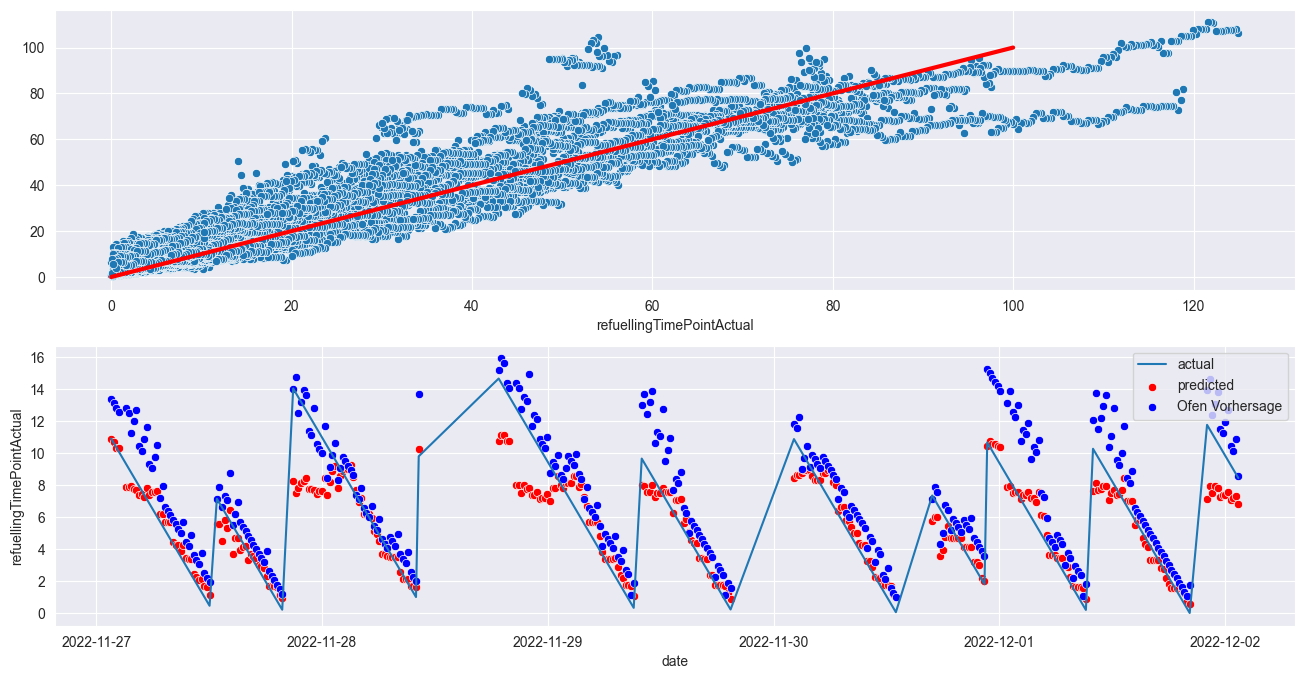

In [5]:
gradientBoostingTrainer.visualize_split()

In [6]:
# k nearest neighbors

from sklearn.neighbors import KNeighborsRegressor

knnTrainer = FurnaceModelTrainer(df, input_columns, slice_step=50, cross_validation_splitter=TimeSeriesSplit(n_splits=5), model_builder=lambda: KNeighborsRegressor(n_neighbors=5))
knnTrainer.cross_validation()

Statistics for this fold: 0.797119237752343, 213.0608294502549, 14.596603353186483
Statistics for this fold: 0.6006804855146912, 211.59271328752536, 14.546226771487008
Statistics for this fold: 0.4557940877867511, 41.639519125501806, 6.452869061549428
Statistics for this fold: 0.5337537144552641, 390.8856756775871, 19.770828907195245
Statistics for this fold: 0.388023045511302, 109.86780694438393, 10.481784530526467
Average MAPE: 0.5550741142040703
Average MSE: 193.4093088970506
Average RSME: 13.907167536815345


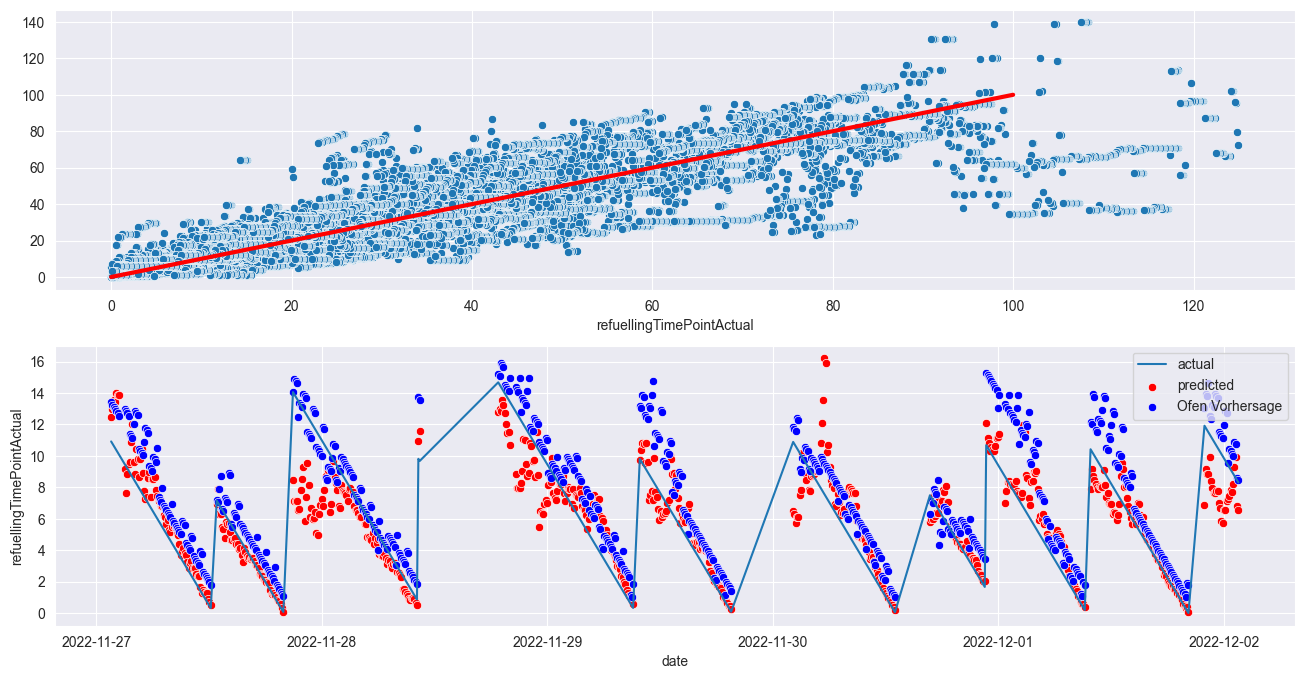

In [7]:
knnTrainer.visualize_split()

In [8]:
# random forest

from sklearn.ensemble import RandomForestRegressor

randomForestTrainer = FurnaceModelTrainer(df, input_columns, slice_step=50, cross_validation_splitter=TimeSeriesSplit(n_splits=5), model_builder=lambda: RandomForestRegressor())
randomForestTrainer.cross_validation()

Statistics for this fold: 0.8808600039913033, 325.248896682272, 18.03465820808013
Statistics for this fold: 0.4350761769172003, 137.0377152383243, 11.706310914986169
Statistics for this fold: 0.21814424832755794, 19.102857300587203, 4.370681560190264
Statistics for this fold: 0.25884688478876416, 234.25521982190818, 15.30539838821284
Statistics for this fold: 0.25018270109574103, 71.59648977524368, 8.461470899036625
Average MAPE: 0.40862200302411333
Average MSE: 157.44823576366707
Average RSME: 12.54783789199028


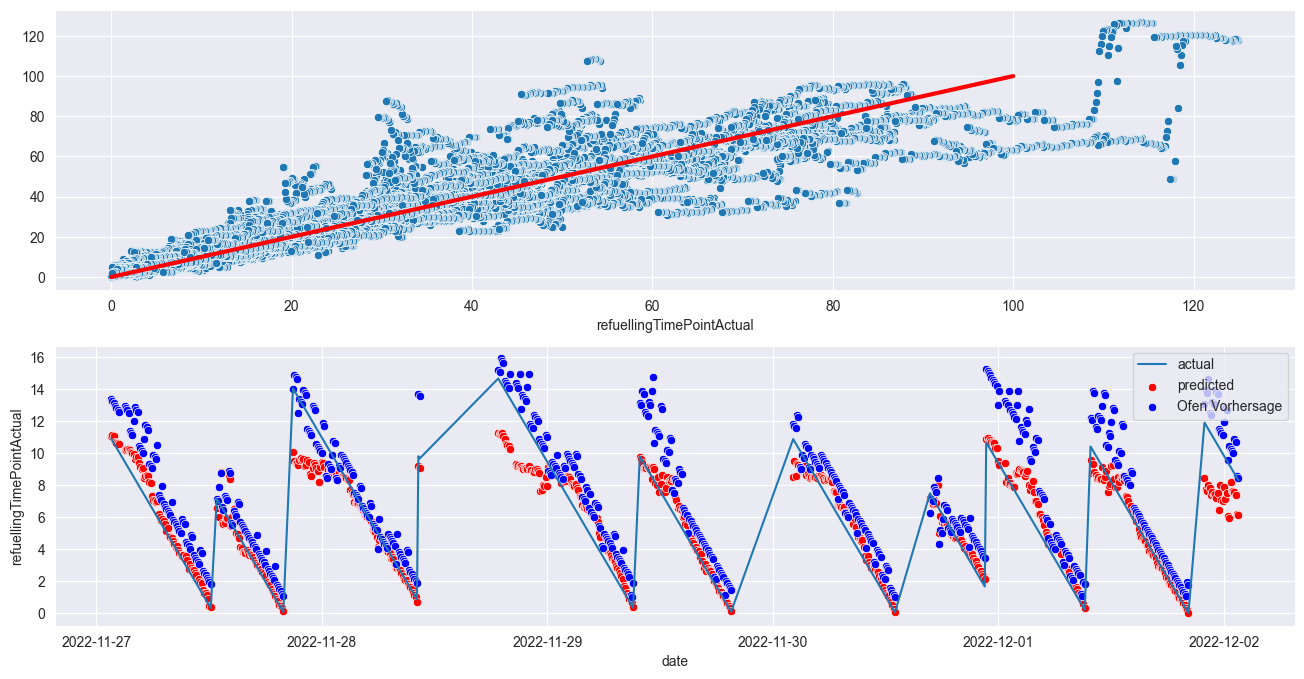

In [9]:
randomForestTrainer.visualize_split()

In [10]:
import xgboost as xgb

model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 1500,
    'learning_rate': 0.08,
    'max_depth': 8,
    'eval_metric': 'mape'
}

xgboostTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=TimeSeriesSplit(n_splits=5), skip_first_cv_splits=2,
    model_builder=lambda: xgb.XGBRegressor(**model_params), fit_params={'verbose': True})
xgboostTrainer.cross_validation()

Statistics for this fold: 0.2743344599270304, 18.32158401210262, 4.280371947868855
Statistics for this fold: 0.2528615460450527, 191.87237715642092, 13.851800502332573
Statistics for this fold: 0.29379465850265457, 56.342781192674934, 7.506182864324246
Average MAPE: 0.2736635548249125
Average MSE: 88.84558078706617
Average RSME: 9.425793377062016


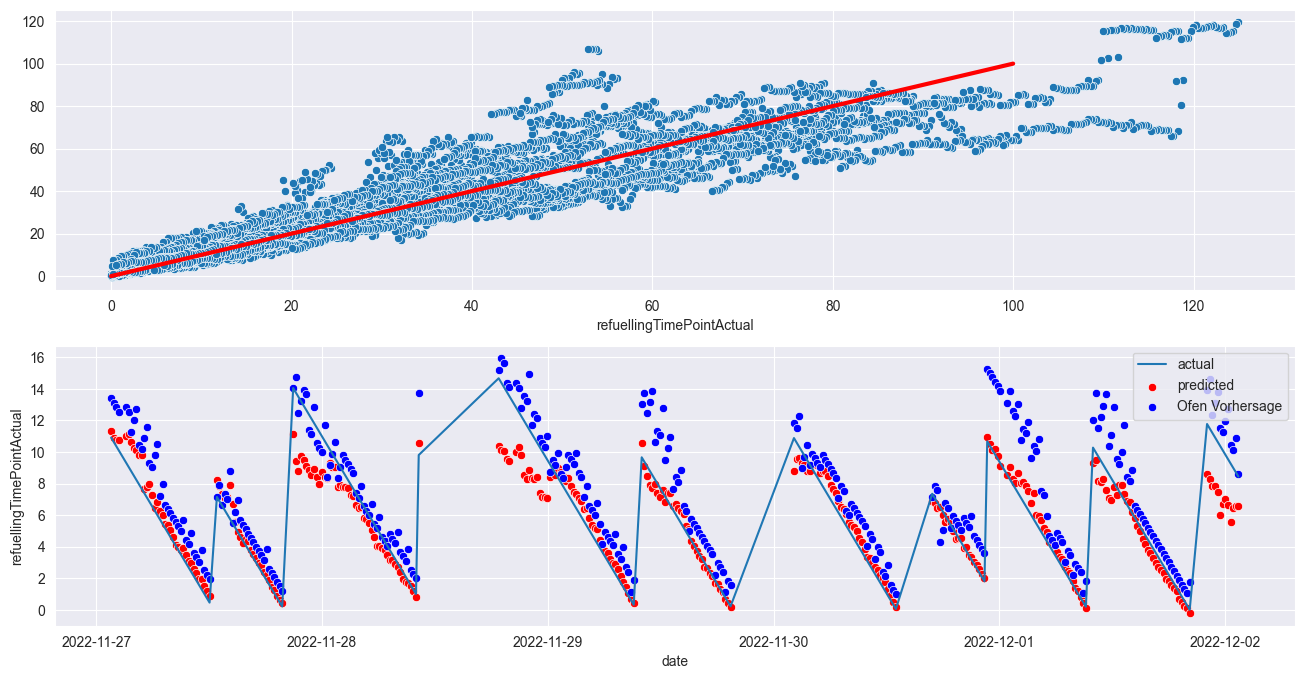

In [11]:
xgboostTrainer.visualize_split()

In [12]:
xgboostTrainer.train()

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

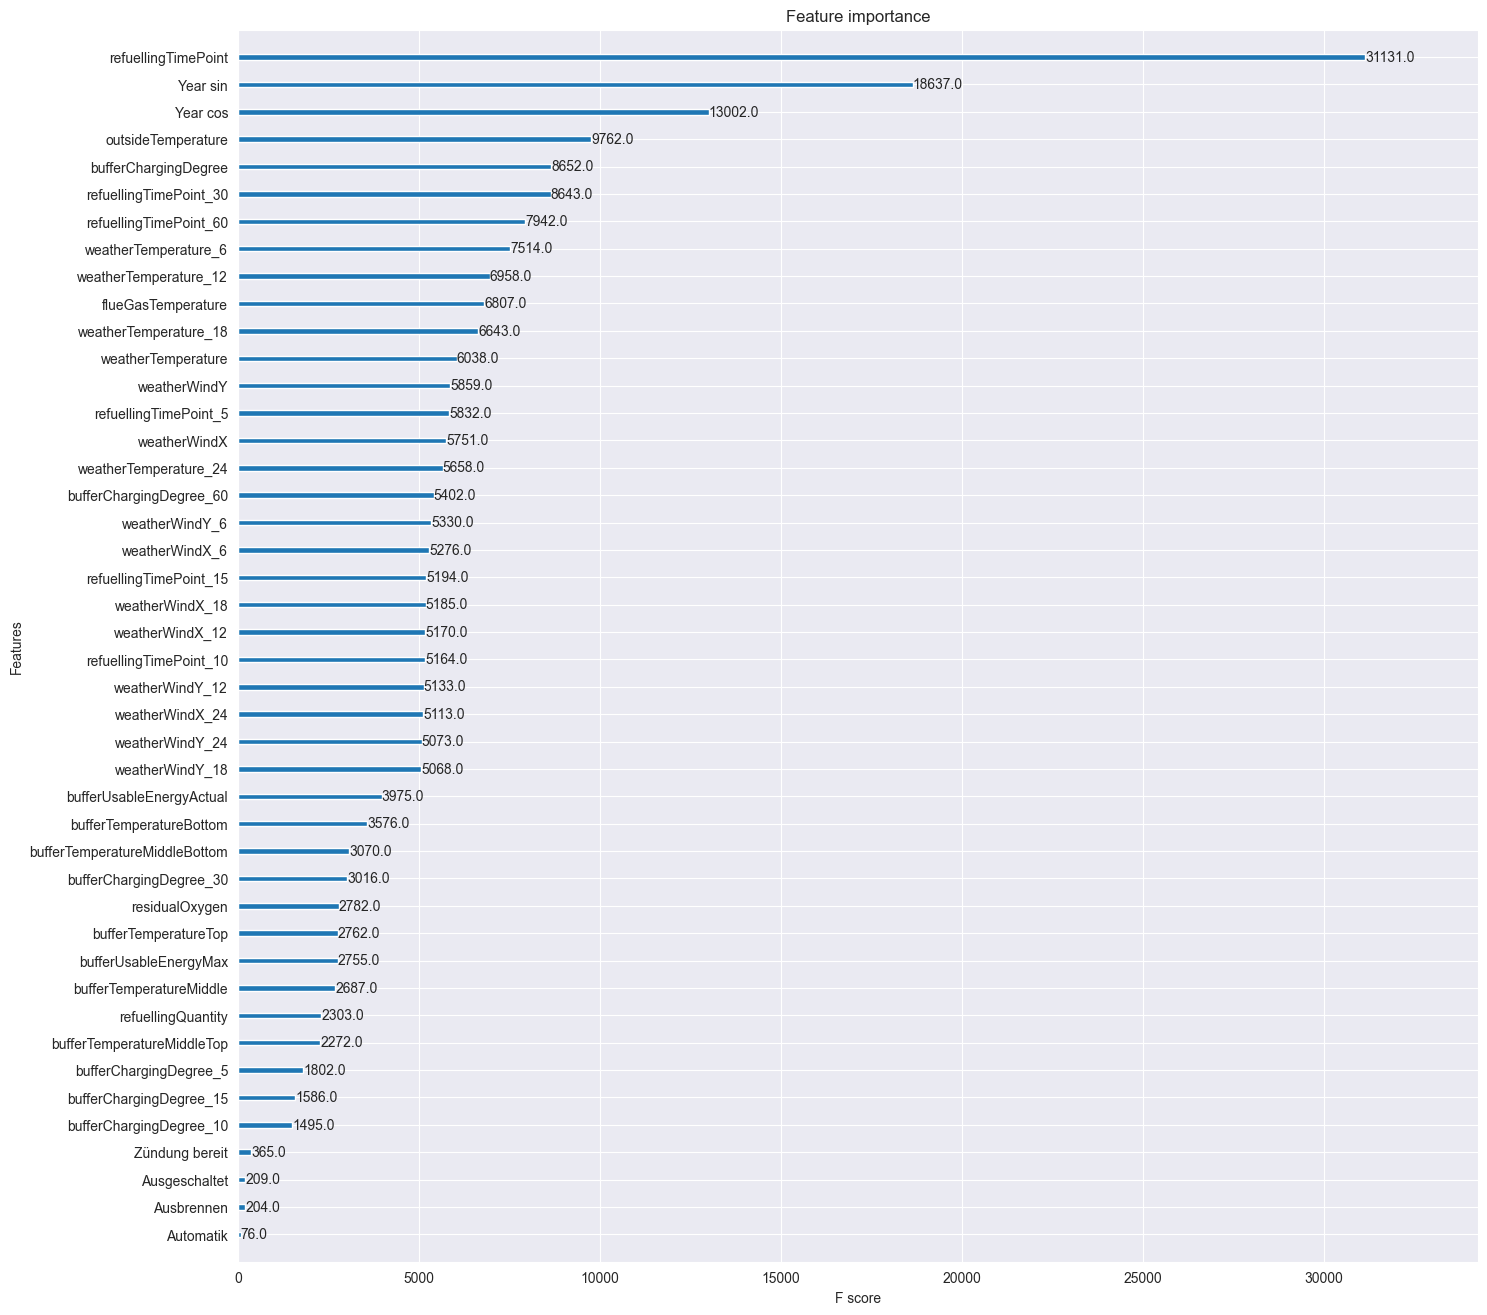

In [13]:
xgb.plot_importance(xgboostTrainer.model)
plt.gcf().set_size_inches(16, 16)
